In [36]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
import itertools
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import matplotlib.pyplot as plt

%matplotlib inline

In [37]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [38]:
SEED = 0
models_results = {
    'Model': [],
    'F-score': [],
    'Precision': [],
    'Recall': [],
    'ROC-AUC': [],
    'Confusion Matrix': []
}

Взять любой набор данных для бинарной классификации,
выбрал https://www.kaggle.com/merishnasuwal/breast-cancer-prediction-dataset 


Описание признаков:

- diagnosis: The diagnosis of breast tissues (1 = malignant, 0 = benign) where - malignant denotes that the disease is harmful
- mean_radius: mean of distances from center to points on the perimeter
- mean_texture: standard deviation of gray-scale values
- mean_perimeter: mean size of the core tumor
- mean_area: mean area of the core tumor
- mean_smoothness: mean of local variation in radius lengths

In [39]:
df = pd.read_csv('Breast_cancer_data.csv')
df.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0


обучить любой классификатор (какой вам нравится) и посчитать метрики качества (roc auc, pr/rec/f1, logloss)

In [40]:
features = df.columns[:-1]
target = 'diagnosis'

In [41]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], random_state=24, test_size=0.2)

In [42]:
clf = xgb.XGBClassifier(random_state=24)

In [43]:
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=24,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [44]:
preds = clf.predict_proba(X_test)[:, 1]

In [45]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
print(f'Roc-Auc: {round(roc_auc_score(y_test, preds), 3)}')

Best Threshold=0.195674, F-Score=0.935, Precision=0.889, Recall=0.986
Roc-Auc: 0.968


Confusion matrix, without normalization
[[32  9]
 [ 2 71]]


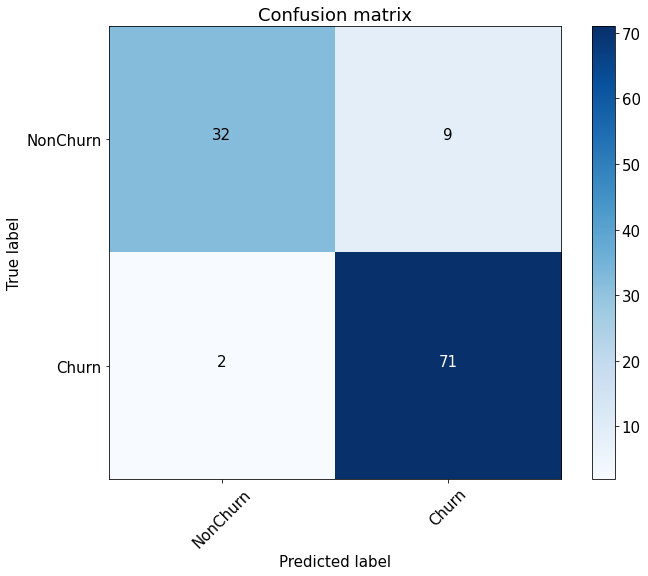

In [46]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [47]:
models_results['Model'].append('XGBClassifier')
models_results['F-score'].append(fscore[ix])
models_results['Precision'].append(precision[ix])
models_results['Recall'].append(recall[ix])
models_results['ROC-AUC'].append(roc_auc_score(y_test, preds))
models_results['Confusion Matrix'].append(cnf_matrix)

Попробуем PU

In [48]:
mod_data = df.copy()
#get the indices of the positives samples
pos_ind = np.where(mod_data.iloc[:,-1].values == 1)[0]
#shuffle them
np.random.shuffle(pos_ind)
# leave just 25% of the positives marked
pos_sample_len = int(np.ceil(0.25 * len(pos_ind)))
print(f'Using {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest')
pos_sample = pos_ind[:pos_sample_len]

Using 90/357 as positives and unlabeling the rest


In [49]:
mod_data['class_test'] = -1
mod_data.loc[pos_sample,'class_test'] = 1
print('target variable:\n', mod_data.iloc[:,-1].value_counts())

target variable:
 -1    479
 1     90
Name: class_test, dtype: int64


In [50]:
x_data = mod_data.iloc[:,:-2].values # just the X 
y_labeled = mod_data.iloc[:,-1].values # new class (just the P & U)
y_positive = mod_data.iloc[:,-2].values # original class

random negative sampling

In [51]:
mod_data = mod_data.sample(frac=1)
neg_sample = mod_data[mod_data['class_test']==-1][:len(mod_data[mod_data['class_test']==1])]
sample_test = mod_data[mod_data['class_test']==-1][len(mod_data[mod_data['class_test']==1]):]
pos_sample = mod_data[mod_data['class_test']==1]
print(neg_sample.shape, pos_sample.shape)
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

(90, 7) (90, 7)


In [52]:
model = xgb.XGBClassifier()

model.fit(sample_train.iloc[:,:-2].values, 
          sample_train.iloc[:,-2].values)
preds = model.predict(sample_test.iloc[:,:-2].values)


In [53]:
precision, recall, thresholds = precision_recall_curve(sample_test.iloc[:,-2].values, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
print(f'Roc-Auc: {round(roc_auc_score(sample_test.iloc[:,-2].values, preds), 3)}')

Best Threshold=1.000000, F-Score=0.897, Precision=0.813, Recall=1.000
Roc-Auc: 0.872


In [54]:
models_results['Model'].append('PU Learn XGBClassifier')
models_results['F-score'].append(fscore[ix])
models_results['Precision'].append(precision[ix])
models_results['Recall'].append(recall[ix])
models_results['ROC-AUC'].append(roc_auc_score(sample_test.iloc[:,-2].values, preds))
models_results['Confusion Matrix'].append(cnf_matrix)

In [55]:
pd.DataFrame(data=models_results).sort_values('ROC-AUC', ascending=False)

,Model,F-score,Precision,Recall,ROC-AUC,Confusion Matrix
0,XGBClassifier,0.935065,0.888889,0.986301,0.967758,"[[32, 9], [2, 71]]"
1,PU Learn XGBClassifier,0.897155,0.813492,1.000000,0.872283,"[[32, 9], [2, 71]]"


поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)

In [56]:
mod_data = df.copy()
#get the indices of the positives samples
pos_ind = np.where(mod_data.iloc[:,-1].values == 1)[0]
#shuffle them
np.random.shuffle(pos_ind)
pos_sample_len = int(np.ceil(0.5 * len(pos_ind)))
print(f'Using {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest')
pos_sample = pos_ind[:pos_sample_len]

Using 179/357 as positives and unlabeling the rest


In [57]:
mod_data['class_test'] = -1
mod_data.loc[pos_sample,'class_test'] = 1
print('target variable:\n', mod_data.iloc[:,-1].value_counts())

target variable:
 -1    390
 1    179
Name: class_test, dtype: int64


In [58]:
x_data = mod_data.iloc[:,:-2].values # just the X 
y_labeled = mod_data.iloc[:,-1].values # new class (just the P & U)
y_positive = mod_data.iloc[:,-2].values # original class

In [59]:
mod_data = mod_data.sample(frac=1)
neg_sample = mod_data[mod_data['class_test']==-1][:len(mod_data[mod_data['class_test']==1])]
sample_test = mod_data[mod_data['class_test']==-1][len(mod_data[mod_data['class_test']==1]):]
pos_sample = mod_data[mod_data['class_test']==1]
print(neg_sample.shape, pos_sample.shape)
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

(179, 7) (179, 7)


In [60]:
model = xgb.XGBClassifier()

model.fit(sample_train.iloc[:,:-2].values, 
          sample_train.iloc[:,-2].values)
preds = model.predict(sample_test.iloc[:,:-2].values)

In [61]:
precision, recall, thresholds = precision_recall_curve(sample_test.iloc[:,-2].values, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
print(f'Roc-Auc: {round(roc_auc_score(sample_test.iloc[:,-2].values, preds), 3)}')

Best Threshold=1.000000, F-Score=0.911, Precision=0.857, Recall=0.971
Roc-Auc: 0.906


In [62]:
models_results['Model'].append('PU Learn XGBClassifier P = 0.5')
models_results['F-score'].append(fscore[ix])
models_results['Precision'].append(precision[ix])
models_results['Recall'].append(recall[ix])
models_results['ROC-AUC'].append(roc_auc_score(sample_test.iloc[:,-2].values, preds))
models_results['Confusion Matrix'].append(cnf_matrix)

In [63]:
mod_data = df.copy()
#get the indices of the positives samples
pos_ind = np.where(mod_data.iloc[:,-1].values == 1)[0]
#shuffle them
np.random.shuffle(pos_ind)
pos_sample_len = int(np.ceil(0.1 * len(pos_ind)))
print(f'Using {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest')
pos_sample = pos_ind[:pos_sample_len]

Using 36/357 as positives and unlabeling the rest


In [64]:
mod_data['class_test'] = -1
mod_data.loc[pos_sample,'class_test'] = 1
print('target variable:\n', mod_data.iloc[:,-1].value_counts())

target variable:
 -1    533
 1     36
Name: class_test, dtype: int64


In [65]:
x_data = mod_data.iloc[:,:-2].values # just the X 
y_labeled = mod_data.iloc[:,-1].values # new class (just the P & U)
y_positive = mod_data.iloc[:,-2].values # original class

In [66]:
mod_data = mod_data.sample(frac=1)
neg_sample = mod_data[mod_data['class_test']==-1][:len(mod_data[mod_data['class_test']==1])]
sample_test = mod_data[mod_data['class_test']==-1][len(mod_data[mod_data['class_test']==1]):]
pos_sample = mod_data[mod_data['class_test']==1]
print(neg_sample.shape, pos_sample.shape)
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

(36, 7) (36, 7)


In [68]:
model = xgb.XGBClassifier()

model.fit(sample_train.iloc[:,:-2].values, 
          sample_train.iloc[:,-2].values)
preds = model.predict(sample_test.iloc[:,:-2].values)

In [69]:
precision, recall, thresholds = precision_recall_curve(sample_test.iloc[:,-2].values, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
print(f'Roc-Auc: {round(roc_auc_score(sample_test.iloc[:,-2].values, preds), 3)}')

Best Threshold=1.000000, F-Score=0.908, Precision=0.846, Recall=0.980
Roc-Auc: 0.857


In [70]:
models_results['Model'].append('PU Learn XGBClassifier P = 0.1')
models_results['F-score'].append(fscore[ix])
models_results['Precision'].append(precision[ix])
models_results['Recall'].append(recall[ix])
models_results['ROC-AUC'].append(roc_auc_score(sample_test.iloc[:,-2].values, preds))
models_results['Confusion Matrix'].append(cnf_matrix)

In [71]:
pd.DataFrame(data=models_results).sort_values('ROC-AUC', ascending=False)

,Model,F-score,Precision,Recall,ROC-AUC,Confusion Matrix
0,XGBClassifier,0.935065,0.888889,0.986301,0.967758,"[[32, 9], [2, 71]]"
2,PU Learn XGBClassifier P = 0.5,0.910714,0.857143,0.971429,0.905526,"[[32, 9], [2, 71]]"
1,PU Learn XGBClassifier,0.897155,0.813492,1.000000,0.872283,"[[32, 9], [2, 71]]"
3,PU Learn XGBClassifier P = 0.1,0.908243,0.846377,0.979866,0.856767,"[[32, 9], [2, 71]]"


При увеличение P(следовательно мы уменьшаем кол-во U) метрики растут, при уменьшение падают.